# **0. ЗАГРУЗКА ДАННЫХ**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBoost, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
import sklearn.metrics as metrics

from time import process_time
import time
import warnings
warnings.filterwarnings('ignore');

C:\Users\-\AppData\Local\Temp\ipykernel_18776\2255849495.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_ = pd.read_csv("data\export\export.csv").drop('Unnamed: 0', axis=1)
data_

,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,calls_to_duration,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,age_segment_retired,age_segment_young,flg_season_spring,flg_season_summer,flg_season_winter
0,3.806662,5.351858,0.693147,6.907755,0,93.444,-36.1,5228.1,0,0.052339,...,0,1,0,0,1,0,0,0,1,0
1,3.988984,4.934474,0.693147,6.907755,0,93.200,-42.0,5195.8,0,0.035774,...,0,0,0,0,1,0,0,0,0,0
2,3.367296,5.828946,1.386294,1.945910,2,94.055,-39.8,4991.6,1,0.666667,...,0,1,0,0,0,0,1,0,1,0
3,3.688879,5.225747,1.098612,6.907755,0,93.075,-47.1,5099.1,0,0.052339,...,0,0,0,0,1,0,0,1,0,0
4,4.025352,4.927254,0.693147,1.386294,1,92.201,-31.4,5076.2,1,0.149300,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39378,4.094345,5.407172,0.693147,6.907755,0,94.465,-41.8,5228.1,0,0.052339,...,0,1,0,0,1,0,0,0,1,0
39379,3.465736,5.283204,1.098612,6.907755,0,93.994,-36.4,5191.0,0,0.052339,...,0,1,0,0,1,0,0,1,0,0
39380,3.761200,4.143135,1.386294,6.907755,0,93.994,-36.4,5191.0,0,0.004937,...,0,0,0,1,1,0,0,1,0,0
39381,3.891820,5.303305,1.098612,6.907755,0,92.431,-26.9,5017.5,0,0.052339,...,0,0,1,0,1,0,0,0,0,0


# **1. ПРЕДОБРАБОТКА**
## 1.1 Разеделение выборки на тренировочную и тестовую части

Примечание: Наблюдается отрицательное влияние скалирования и фильтрации признаков

In [3]:
data_.dropna(inplace=True)
# Наблюдается отрицательный эффект от применения скалирования 
from sklearn.feature_selection import SelectFromModel
X, y = data_.drop('y', axis=1), data_.y

#lr = LogisticRegression(penalty='l2').fit(X,y)
#X = SelectFromModel(lr, prefit=True, max_features=100).transform(X=X)

scaler = StandardScaler().fit_transform(X=X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=0)


## 1.2 Соотношение классов, ребалансировка

Примечание: Для ребалансировки классов выполнен даунсемплинг в соотношении 1:2

In [4]:
X, y = data_.drop('y', axis=1), data_.y
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=0)

In [5]:
print(f'СООТНОШЕНИЕ КЛАССОВ ДО РЕБАЛАНСИРОВКИ :\n{y_train.value_counts()}')

# Получаем индексы для балансировки классов
index_for_balancing = np.random.choice(X_train[y_train == 0].index, 
                                       size=len(X_train[y_train == 1])*2, 
                                       replace=False)
# Обновляем индексы с учетом класса 1
index_for_balancing = np.concatenate((index_for_balancing, 
                                      y_train[y_train == 1].index))
X_train = X_train.loc[index_for_balancing]
y_train = y_train.loc[index_for_balancing]

print(f'\nСООТНОШЕНИЕ КЛАССОВ ПОСЛЕ РЕБАЛАНСИРОВКИ :\n{y_train.loc[index_for_balancing].value_counts()}')
print('\nБалансировка применена, переменные X_train, y_train переназначены !')


СООТНОШЕНИЕ КЛАССОВ ДО РЕБАЛАНСИРОВКИ :
y
0    26485
1     3050
Name: count, dtype: int64

СООТНОШЕНИЕ КЛАССОВ ПОСЛЕ РЕБАЛАНСИРОВКИ :
y
0    6100
1    3050
Name: count, dtype: int64

Балансировка применена, переменные X_train, y_train переназначены !


In [ ]:
# # Занесем их в датафрейм для сравнения с gridsearch
# metrics = pd.DataFrame(index=['roc_auc_score', 
#                               'precision_score', 
#                               'recall_score', 
#                               'f1_score', 
#                               'log_loss'])
# metrics['Baseline_model'] = [roc_auc_score(y_score=y_score, y_true=y_test),
#                              precision_score(y_true=y_test, y_pred=y_pred),
#                              recall_score(y_true=y_test, y_pred=y_pred),
#                              f1_score(y_true=y_test, y_pred=y_pred),
#                              log_loss(y_true=y_test, y_pred=y_pred)]

In [12]:
import time
training_times = []
def print_status(message):
    print("Старт обучения:", message)
def time_note(start_time):
    training_time = start_time - time.time()
    training_times.append(training_time)
    print(f'training_time: {training_time}')
# Обучение моделей

print_status("Логистическая регрессия")
start_time = time.time()
clf = LogisticRegression(random_state=17, 
                        C=0.1, 
                        penalty='l2', 
                        solver="newton-cg")
clf.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

Старт обучения: Логистическая регрессия
training_time: -0.5286881923675537
------------------------------------------------------


# **2. ВСЕ МОДЕЛИ**

In [13]:
# Функция для вывода состояния выполнения
training_times = []
def print_status(message):
    print("Старт обучения:", message)
def time_note(start_time):
    training_time = start_time - time.time()
    training_times.append(training_time)
    print(f'Время обучения: {training_time}')
# Обучение моделей

print_status("Логистическая регрессия")
start_time = time.time()
clf = LogisticRegression(random_state=17, 
                        C=0.1, 
                        penalty='l2', 
                        solver="newton-cg")
clf.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Случайный лес")
start_time = time.time()
rf = RandomForestClassifier(criterion='entropy', 
                        max_depth=20,
                        max_features='sqrt',
                        min_samples_leaf=2,
                        min_samples_split=2, 
                        random_state=11, 
                        n_estimators=250)
rf.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("XGBoost")
start_time = time.time()
XGB = XGBClassifier(verbosity=0, 
                        max_depth=5, 
                        n_estimators=100, 
                        reg_alpha=0.1, 
                        reg_lambda=100, 
                        sampling_method='uniform')
xgb_model = XGB.fit(X_train, 
                        y_train, 
                        eval_metric="auc", 
                        eval_set=[(X_test, y_test)], 
                        early_stopping_rounds=20)
time_note(start_time)
print("------------------------------------------------------")

print_status("Градиентный бустинг")
start_time = time.time()
GB = GBoost(loss='exponential', 
                        max_depth=3, 
                        n_estimators=50)
GB.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("LightGBM")
start_time = time.time()
lgb = lgb.LGBMClassifier(learning_rate=0.1,
                        verbosity=0, 
                        max_depth=5,
                        num_leaves=31, 
                        n_estimators=100, 
                        reg_alpha=0, 
                        reg_lambda=1, 
                        )
lgb.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Нейронная сеть")
start_time = time.time()
nn = MLPClassifier(activation='logistic', 
                        solver='adam', 
                        hidden_layer_sizes=(100, 100),
                        
                        )
nn.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Линейный дискриминантный анализ")
start_time = time.time()
lda = LDA()
lda.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Метод опорных векторов")
start_time = time.time()
svm = SVC(gamma='auto', probability=True)
svm.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Наивный байесовский классификатор")
start_time = time.time()
Bayes = GaussianNB()
Bayes.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print_status("Метод ближайших соседей")
start_time = time.time()
neigh = KNeighborsClassifier(algorithm='auto',
                            leaf_size=10,
                            metric='manhattan', 
                            n_neighbors=9, 
                            weights='distance')
neigh.fit(X_train, y_train)
time_note(start_time)
print("------------------------------------------------------")

print('Завершено !')


Старт обучения: Логистическая регрессия
training_time: -0.5402576923370361
------------------------------------------------------
Старт обучения: Случайный лес
training_time: -1.9781160354614258
------------------------------------------------------
Старт обучения: XGBoost
[0]	validation_0-auc:0.91168
[1]	validation_0-auc:0.92258
[2]	validation_0-auc:0.92520
[3]	validation_0-auc:0.93131
[4]	validation_0-auc:0.93416
[5]	validation_0-auc:0.93535
[6]	validation_0-auc:0.93613
[7]	validation_0-auc:0.93737
[8]	validation_0-auc:0.93825
[9]	validation_0-auc:0.93927
[10]	validation_0-auc:0.94042
[11]	validation_0-auc:0.94128
[12]	validation_0-auc:0.94165
[13]	validation_0-auc:0.94232
[14]	validation_0-auc:0.94291
[15]	validation_0-auc:0.94334
[16]	validation_0-auc:0.94378
[17]	validation_0-auc:0.94423
[18]	validation_0-auc:0.94435
[19]	validation_0-auc:0.94489
[20]	validation_0-auc:0.94499
[21]	validation_0-auc:0.94528
[22]	validation_0-auc:0.94548
[23]	validation_0-auc:0.94565
[24]	validation_

# **3. СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ**
### Подготовим списки наименований и показатели метрик моделей для оформления чертежа

In [14]:
names = ['log reg', 'rf', 'XGB', 'GB', 'LGBM', 'NN', 'LDA', 'SVM', 'Bayes', 'KNN']

# Подготовка данных для барплота сравнения метрик. Дублирование имен под тренировочную и тестовую часть 
names2 = [i + ", " + i for i in names]
names2 = ', '.join(names2)
names2 = names2.split(', ')

# Создание списков для хранения результатов оценки для оценки моделей машинного обучения
models = [clf, rf, XGB, GB, lgb, nn, lda, svm, Bayes, neigh]
test_list = []
to_pred_list = []

# Выполнение оценки для каждой. Вычисление ROC AUC на  тренировочном и тестовом наборе
for model in models:
    test_list.append(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    to_pred_list.append(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Подготовка списка имен моделей для вывода
names = ['log reg', 'rf', 'XGB', 'GB', 'LGBM', 'NN', 'LDA', 'SVM', 'Bayes', 'KNN']
names2 = [i + ", " + i for i in names]
# Преобразование списка имен в строку и разделение строки на список имен
names2 = ', '.join(names2)
names2 = names2.split(', ')

print(names2)
# Создание массива данных для вывода результатов и преобразование списка списков в одномерный массив для отрисовки
data = [[test_list[i], to_pred_list[i]] for i in range(len(models))]
data = np.array(data).flatten()
print(data)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
['log reg', 'log reg', 'rf', 'rf', 'XGB', 'XGB', 'GB', 'GB', 'LGBM', 'LGBM', 'NN', 'NN', 'LDA', 'LDA', 'SVM', 'SVM', 'Bayes', 'Bayes', 'KNN', 'KNN']
[0.9292531  0.9315442  0.99760946 0.94675164 0.96398379 0.94860695
 0.94710618 0.94295103 0.96767898 0.947818   0.79664531 0.80313747
 0.93122612 0.9307292  0.94056321 0.93272817 0.86123867 0.86275089
 1.         0.91489842]


<Figure size 1200x800 with 0 Axes>

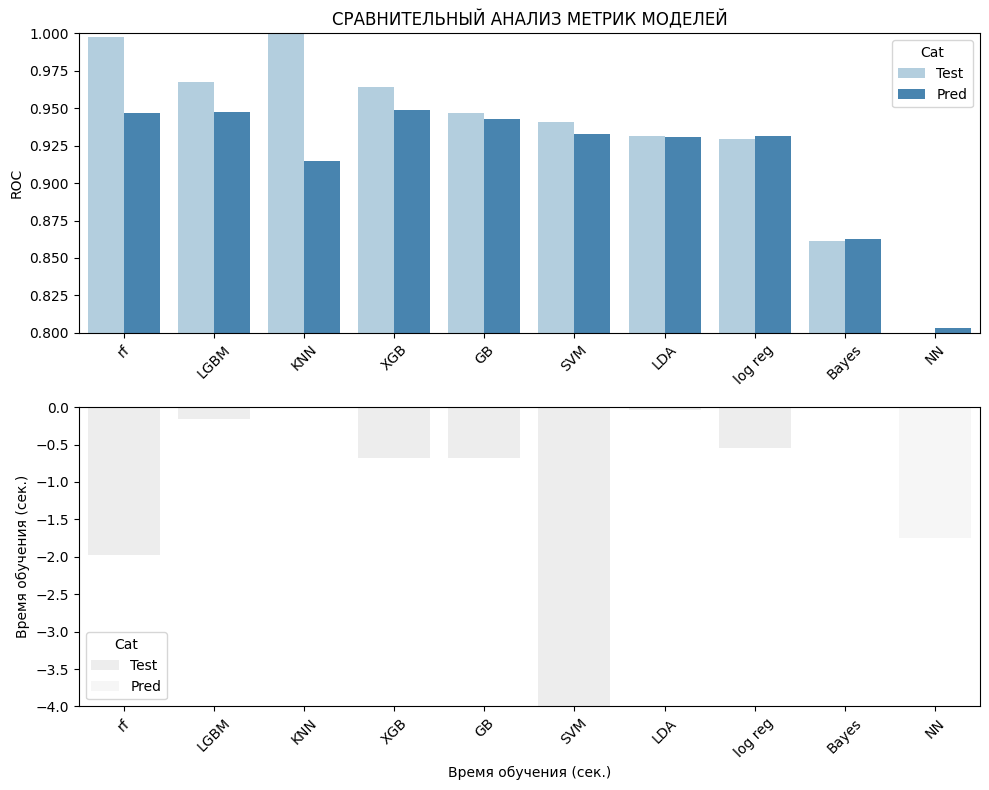

In [81]:
# Обновление диаграммы с добавлением времени обучения
plt.figure(figsize=(12, 8))  # Увеличиваем размер графика

# Создание словаря с данными
datal = {'Name': names2,
        'Data': data,
        'Training Time (sec)': np.repeat(training_times, 2),
        'Cat': ['Test', 'Pred'] * 10}
df1 = pd.DataFrame(datal)

# Добавление столбца средних значений по группе Name для последующей соритировки
df1['diff'] = df1.groupby('Name').Data.transform('mean')
df1 = df1.sort_values('diff', ascending=False)

# Создание subplot с двумя рядами и одним столбцом
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Первый subplot для test и pred
sns.barplot(x='Name', y='Data', data=df1, hue='Cat', palette='Blues', ax=axes[0])
axes[0].set_title('СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТРИК МОДЕЛЕЙ')
axes[0].set_xlabel('') 
axes[0].set_ylim(0.8, 1)  # Ограничение для верхнего графика
axes[0].set_ylabel('ROC')
# Второй subplot для времени обучения
sns.barplot(x='Name', y='Training Time (sec)', data=df1.iloc[::2], hue='Cat', palette='grey', ax=axes[1], alpha=0.1 )
#axes[1].set_title('Время обучения')
axes[1].set_ylabel('Время обучения (сек.)')  # Добавляем подпись для оси y
axes[1].set_xlabel('Время обучения (сек.)')
axes[1].set_ylim(-4,0)
 
# Устанавливаем поворот меток на оси x для лучшей читаемости в обоих subplot
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Добавляем выравнивание
plt.show()

# **4 ПОИСК ПАРАМЕТРОВ**

### 4.0 Общие настройки вывода графики ROC_AUC / Precision_Recall

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score 
import time 

# Функция для вывода результатов оценки модели - отчета о классификации и площади под ROC-кривой
def results(y_test, y_pred, time=0):
    report = metrics.classification_report(y_test, y_pred, target_names=['recovered', 'uncovered'])
    print(report)
    print("\nПлощадь под ROC-кривой - " + str(round(metrics.roc_auc_score(y_test, y_pred), 4)))
    
def ROC_curve(y_test, model):
    # Создание полотна для графиков
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
    lw = 2  # Ширина линии на графике

    axes[0].plot(fpr, tpr, lw=lw, label='ROC curve')
    axes[0].plot([0, 1], [0, 1])  # Диагональная линия
    axes[0].set_xlim([0.0, 1.0])  # Предел по оси X
    axes[0].set_ylim([0.0, 1.05])  # Предел по оси Y
    axes[0].set_xlabel('False Positive Rate')  # Подпись оси X
    axes[0].set_ylabel('True Positive Rate')  # Подпись оси Y
    axes[0].set_title('ROC curve')  # Заголовок графика

    # Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)

    axes[1].plot(recall, precision, lw=lw, label='Precision-Recall curve')
    axes[1].set_xlim([0.0, 1.0])  # Предел по оси X
    axes[1].set_ylim([0.0, 1.05])  # Предел по оси Y
    axes[1].set_xlabel('Recall')  # Подпись оси X
    axes[1].set_ylabel('Precision')  # Подпись оси Y
    axes[1].set_title('Precision-Recall curve')  # Заголовок графика

    # Сохранение графика
    plt.savefig("ROC_and_Precision_Recall.png")
    plt.show()  # Отображение графика

## 4.1 **Логистическая регрессия**

              precision    recall  f1-score   support

   recovered       0.99      0.85      0.91      8829
   uncovered       0.40      0.89      0.55      1017

    accuracy                           0.85      9846
   macro avg       0.69      0.87      0.73      9846
weighted avg       0.92      0.85      0.87      9846


Площадь под ROC-кривой - 0.8685
------------------------------------------------------
Площадь под ROC-кривой по вероятностям: 0.9334003224838062


Результат на оценочной выборке: 0.9327988918257111


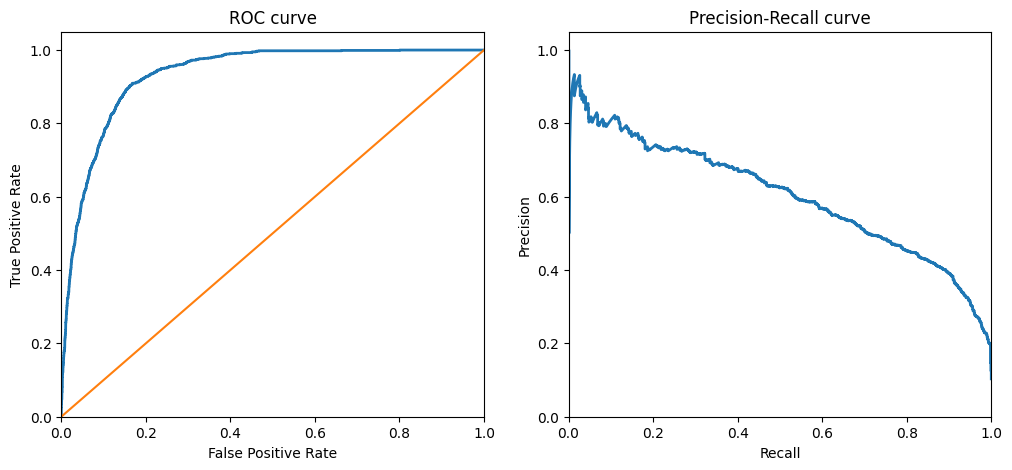

In [74]:
# Обучение и предсказание модели

start_time = process_time()
clf = LogisticRegression(random_state=0, 
                         C=0.1, penalty='l2', 
                         solver='newton-cg', 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Оценка результатов и времени выполнения
finish_time = process_time()
sec = finish_time - start_time
results(y_test, y_pred, sec)
print("------------------------------------------------------")

# Оценка качества модели
print('Площадь под ROC-кривой по вероятностям: ' + str(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])))
print("\n")
print('Результат на оценочной выборке: ' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
ROC_curve(y_test, clf)


### 4.1.1 Подбор параметров

In [84]:
start_time = process_time()
# Определим параметры для поиска по сетке
parameters = {
    'C': np.logspace(-4, 3, 8),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
# GridSearchCV для модели LogisticRegression
gr_lr = GridSearchCV(LogisticRegression(solver='saga', 
                                        n_jobs=-1, 
                                        random_state=17), 
                                        parameters, cv=5, 
                                        scoring="roc_auc")
gr_lr.fit(X_train, y_train)

finish_time = process_time()
sec = finish_time - start_time

print(f'Время работы \t:{round(sec / 60),round(sec % 60)}')
print(f'Лучшие параметры :{gr_lr.best_params_}')

Время работы 	:(3, 17)
Лучшие параметры :{'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}


## **4.2 Случайный лес Random forest**

              precision    recall  f1-score   support

   recovered       0.94      0.98      0.96      8829
   uncovered       0.70      0.50      0.58      1017

    accuracy                           0.93      9846
   macro avg       0.82      0.74      0.77      9846
weighted avg       0.92      0.93      0.92      9846


Площадь под ROC-кривой - 0.7367

Площадь под ROC-кривой по вероятностям1.0

Результат на оценочной выборке0.949359584537102


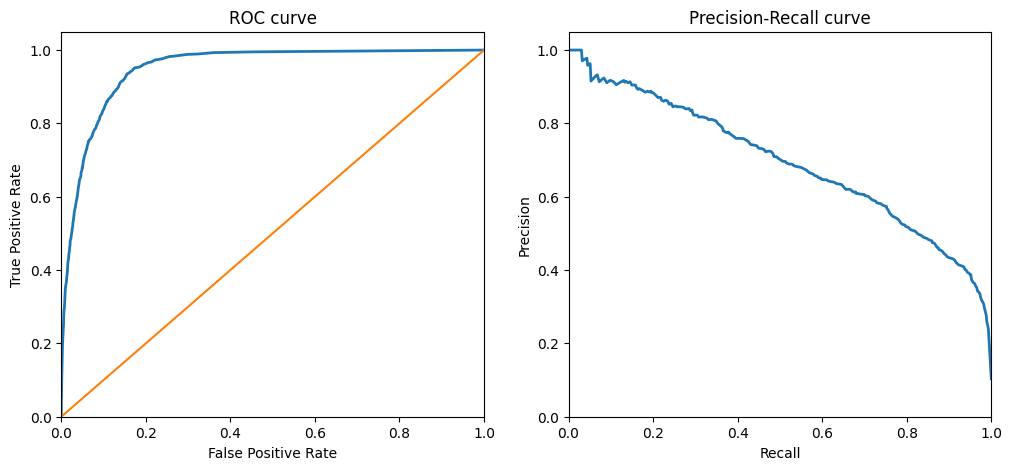

In [76]:
start_time = process_time()
# Создание экземпляра классификатора Random Forest с указанными параметрами
rf = RandomForestClassifier (n_estimators= 250, 
                             max_depth=None, 
                             random_state=11, 
                             criterion='entropy', 
                             class_weight='balanced')
# Обучение модели
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

finish_time = process_time()
sec = finish_time - start_time

# Вывод результатов
results(y_test, y_pred, sec)
print('\nПлощадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])))
print('\nРезультат на оценочной выборке' + str(metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])))
# Визуализация ROC-кривой
ROC_curve(y_test, rf)

### 4.2.1 Подбор параметров

In [27]:
# Определим параметры для поиска по сетке
parameters = {
    'n_estimators': [100, 200, 250],  # количество деревьев
    'max_depth': [None, 10, 20, 30],  # максимальная глубина деревьев
    'criterion': ['gini', 'entropy'],  # критерий для разделения
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок, необходимое для разделения внутреннего узла
    'min_samples_leaf': [2, 4, 6],  # минимальное количество выборок, необходимое для нахождения в листе
    #'max_features': ['auto', 'sqrt', 'log2']  # максимальное количество признаков для разделения
}
start_time = process_time()
# GridSearchCV для модели RandomForestClassifier
gr_rf = GridSearchCV(RandomForestClassifier(random_state=11), 
                     parameters, 
                     cv=5, 
                     scoring="roc_auc", 
                     n_jobs=-1)

# Выполнение поиска по сетке
gr_rf.fit(X_train, y_train)
# Таймер
finish_time = process_time()
sec = finish_time - start_time

# Вывод результатов
print(f'Время работы: \t{round(sec)}')
print(f'Лучшие параметры: \t{gr_rf.best_params_}')

Время работы: 	6
Лучшие параметры: 	{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}


## **4.3 Градиентный бустинг Gboost от Scikit-learn**

              precision    recall  f1-score   support

   recovered       0.94      0.97      0.96      8829
   uncovered       0.66      0.49      0.56      1017

    accuracy                           0.92      9846
   macro avg       0.80      0.73      0.76      9846
weighted avg       0.91      0.92      0.92      9846


Площадь под ROC-кривой - 0.7286


Площадь под ROC-кривой по вероятностям0.9520703460356466


Результат на оценочной выборке0.9464719877609018


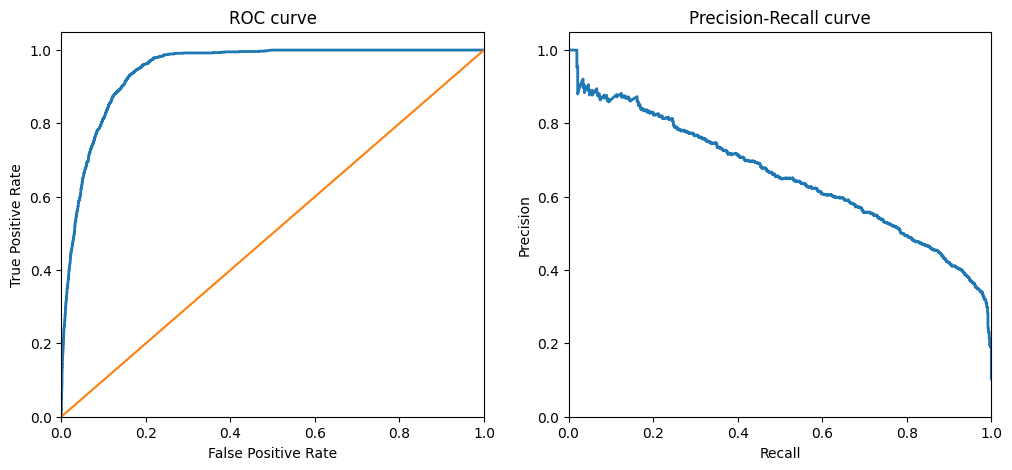

In [77]:
start_time = process_time()
# Инициализация и обучение модели Gradient Boosting
GB = GBoost(loss='exponential', 
            max_depth=3, 
            n_estimators=100)
GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

# Вычисляем время, затраченное на обучение
finish_time = process_time()
sec = finish_time - start_time

# Выводим результаты работы модели
results(y_test, y_pred, sec)
print ("\n")
print('Площадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, GB.predict_proba(X_train)[:,1])))
print("\n")
print('Результат на оценочной выборке' + str(metrics.roc_auc_score(y_test, GB.predict_proba(X_test)[:,1])))
ROC_curve(y_test, GB)

### 4.3.1 Подбор параметров

In [32]:
parameters = {
    'loss': ['deviance', 'exponential'],  # функция потерь
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'n_estimators': [50, 100, 150, 200]  # количество деревьев
}

# Создание объекта GridSearchCV для модели GradientBoostingClassifier
gr_gb = GridSearchCV(GBoost(random_state=17), 
                            parameters, 
                            cv=5, 
                            scoring="roc_auc", 
                            n_jobs=-1)

start_time = process_time()
gr_gb.fit(X_train, y_train)
finish_time = process_time()

# Вычисление времени выполнения
sec = finish_time - start_time

# Вывод результатов
print(f'Время работы: {round(sec / 60), round(sec % 60)}')
print(f'Лучшие параметры: {gr_gb.best_params_}')

Время работы: (0, 30)
Лучшие параметры: {'loss': 'exponential', 'max_depth': 5, 'n_estimators': 50}


## **4.4 Градиентный бустинг XGB от XGBoost**

[0]	validation_0-auc:0.88724
[1]	validation_0-auc:0.90704
[2]	validation_0-auc:0.91573
[3]	validation_0-auc:0.92889
[4]	validation_0-auc:0.92987
[5]	validation_0-auc:0.93190
[6]	validation_0-auc:0.93446
[7]	validation_0-auc:0.93491


[8]	validation_0-auc:0.93599
[9]	validation_0-auc:0.93653
[10]	validation_0-auc:0.93730
[11]	validation_0-auc:0.93774
[12]	validation_0-auc:0.93817
[13]	validation_0-auc:0.93873
[14]	validation_0-auc:0.93904
[15]	validation_0-auc:0.94020
[16]	validation_0-auc:0.94059
[17]	validation_0-auc:0.94078
[18]	validation_0-auc:0.94138
[19]	validation_0-auc:0.94162
[20]	validation_0-auc:0.94197
[21]	validation_0-auc:0.94210
[22]	validation_0-auc:0.94234
[23]	validation_0-auc:0.94259
[24]	validation_0-auc:0.94303
[25]	validation_0-auc:0.94310
[26]	validation_0-auc:0.94321
[27]	validation_0-auc:0.94328
[28]	validation_0-auc:0.94316
[29]	validation_0-auc:0.94321
[30]	validation_0-auc:0.94352
[31]	validation_0-auc:0.94358
[32]	validation_0-auc:0.94366
[33]	validation_0-auc:0.94419
[34]	validation_0-auc:0.94414
[35]	validation_0-auc:0.94424
[36]	validation_0-auc:0.94471
[37]	validation_0-auc:0.94479
[38]	validation_0-auc:0.94509
[39]	validation_0-auc:0.94534
[40]	validation_0-auc:0.94602
[41]	validat

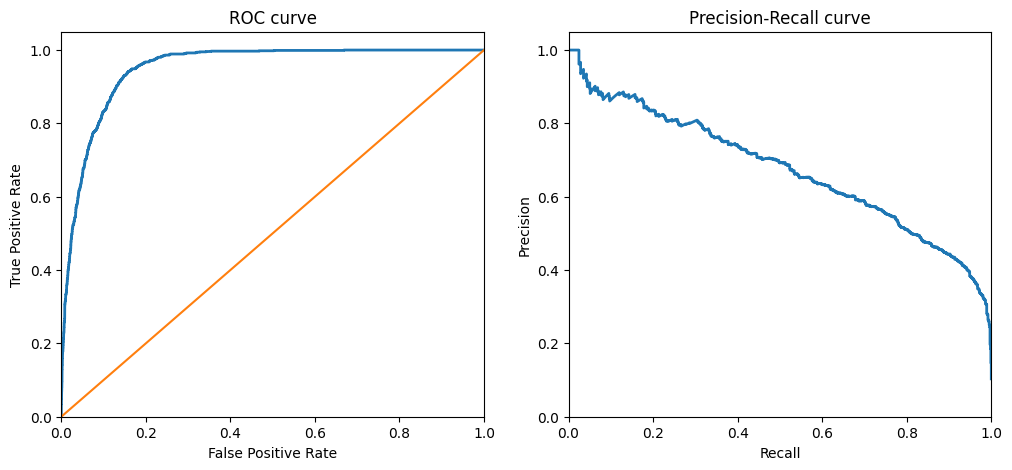

In [78]:
start_time = process_time()

# Обучение модели XGBClassifier
XGB = XGBClassifier(refresh_leaf=0, 
                    verbosity=0, 
                    max_depth=3, 
                    n_estimators=150, 
                    reg_alpha=0, 
                    reg_lambda=10, 
                    sampling_method='uniform')

xgb_model = XGB.fit(X_train, y_train, 
                    eval_metric="auc", 
                    eval_set=[(X_test, y_test)], 
                    early_stopping_rounds=20)

# Предсказание меток классов для тестовой выборки
y_pred = xgb_model.predict(X_test)
# Вычисление времени выполнения и вывод
finish_time = process_time()
sec = finish_time - start_time
results(y_test, y_pred, sec)
print("\n")

# Вычисление и вывод площади под ROC-кривой
print('Площадь под ROC-кривой по вероятностям:', str(metrics.roc_auc_score(y_train, XGB.predict_proba(X_train)[:, 1])))
print("\n")
print('Результат на оценочной выборке:', str(metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:, 1])))
# Построение ROC-кривой
ROC_curve(y_test, XGB)

### 4.4.1 Подбор параметров

In [34]:
# Определение параметров для поиска по сетке
parameters = {
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'n_estimators': [100, 150, 200],  # количество деревьев
    'reg_alpha': [0, 0.1, 0.5],  # коэффициент L1 регуляризации
    'reg_lambda': [1, 10, 100],  # коэффициент L2 регуляризации
    'sampling_method': ['uniform', 'gradient_based']  # метод сэмплирования
}

# Создание объекта GridSearchCV для модели XGBClassifier
gr_xgb = GridSearchCV(XGBClassifier(refresh_leaf=0, verbosity=0), parameters, cv=5, scoring="roc_auc", n_jobs=-1)
start_time = process_time()

# Выполнение поиска по сетке
gr_xgb.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)], early_stopping_rounds=20)

finish_time = process_time()
sec = finish_time - start_time

print(f'Время работы: {round(sec / 60), round(sec % 60)}')
print(f'Лучшие параметры: {gr_xgb.best_params_}')

[0]	validation_0-auc:0.90649
[1]	validation_0-auc:0.91951
[2]	validation_0-auc:0.92986
[3]	validation_0-auc:0.93136
[4]	validation_0-auc:0.93239
[5]	validation_0-auc:0.93399
[6]	validation_0-auc:0.93554
[7]	validation_0-auc:0.93622
[8]	validation_0-auc:0.93674
[9]	validation_0-auc:0.93756
[10]	validation_0-auc:0.93801
[11]	validation_0-auc:0.93847
[12]	validation_0-auc:0.93872
[13]	validation_0-auc:0.93870
[14]	validation_0-auc:0.93891
[15]	validation_0-auc:0.93922
[16]	validation_0-auc:0.93942
[17]	validation_0-auc:0.93965
[18]	validation_0-auc:0.93952
[19]	validation_0-auc:0.93983
[20]	validation_0-auc:0.93994
[21]	validation_0-auc:0.94006
[22]	validation_0-auc:0.94028
[23]	validation_0-auc:0.94046
[24]	validation_0-auc:0.94035
[25]	validation_0-auc:0.94049
[26]	validation_0-auc:0.94041
[27]	validation_0-auc:0.94055
[28]	validation_0-auc:0.94048
[29]	validation_0-auc:0.94049
[30]	validation_0-auc:0.94048
[31]	validation_0-auc:0.94067
[32]	validation_0-auc:0.94082
[33]	validation_0-au

## **4.5 Градиентный бустинг LightGBM от Microsoft**

[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

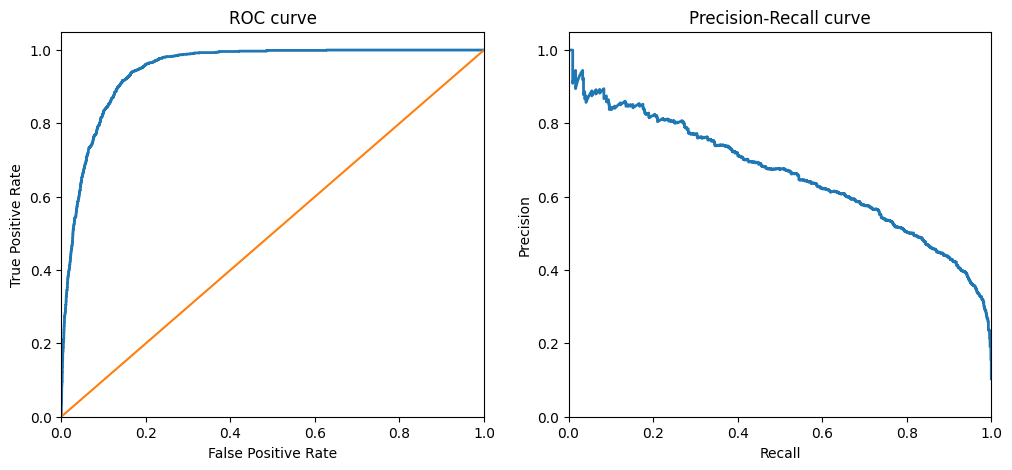

In [79]:
import lightgbm as lgb

# Засекаем время и создаем и обучаем модель LightGBM
start_time = process_time()
lgb_model = lgb.LGBMClassifier(verbosity=0,          # Уровень подробности вывода
                               max_depth=3,          # Максимальная глубина дерева
                               n_estimators=150,    # Количество деревьев в ансамбле
                               reg_alpha=0,          # L1 регуляризация
                               reg_lambda=10,        # L2 регуляризация
                               sampling_method='uniform')  # Метод сэмплирования

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

# Завершаем отсчет времени и вычисляем время обучения
finish_time = process_time()
sec = finish_time - start_time

# Выводим результаты метрик, времени обучения, площадь под ROC-кривой
results(y_test, y_pred, sec)
print('\nПлощадь под ROC-кривой по вероятностям: ' + str(metrics.roc_auc_score(y_train, lgb_model.predict_proba(X_train)[:, 1])))
print("\n")

# Выводим результат на оценочной выборке и рисуем ROC-кривую
print('Результат на оценочной выборке: ' + str(metrics.roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])))
ROC_curve(y_test, lgb_model)

### 4.5.1 Подбор параметров

In [88]:
# Определение параметров для поиска по сетке
parameters = {
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'n_estimators': [100, 200, 300],  # количество деревьев
    'reg_alpha': [0, 0.1, 0.5],  # коэффициент L1 регуляризации
    'reg_lambda': [1, 10, 100],  # коэффициент L2 регуляризации
    'num_leaves': [35, 50, 100]
}

# GridSearchCV для модели LGBMClassifier
gr_lgb = GridSearchCV(lgb.LGBMClassifier(verbosity=0), parameters, cv=5, scoring="roc_auc", n_jobs=-1)

start_time = process_time()
gr_lgb.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)])
finish_time = process_time()
sec = finish_time - start_time

# Вывод результатов
print(f'Время работы: {round(sec)} сек.')
print(f'Лучшие параметры: {gr_lgb.best_params_}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

## **4.6 Метод опорных векторов SVM**

              precision    recall  f1-score   support

   recovered       0.93      0.99      0.96      8829
   uncovered       0.73      0.34      0.46      1017

    accuracy                           0.92      9846
   macro avg       0.83      0.66      0.71      9846
weighted avg       0.91      0.92      0.91      9846


Площадь под ROC-кривой - 0.6619


Площадь под ROC-кривой по вероятностям0.929663607919113


Результат на оценочной выборке0.9056247663321897


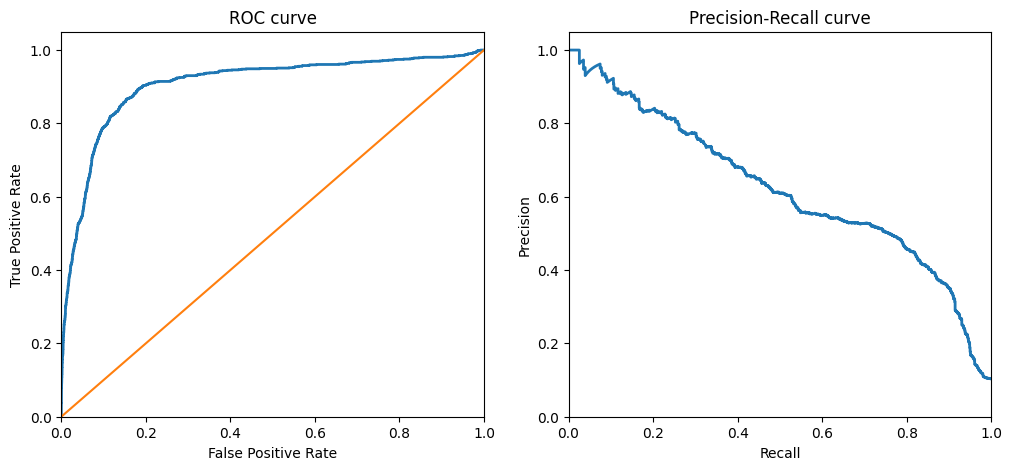

In [80]:
start_time = process_time()

# Создаем модель SVM с указанными параметрами и обучаем модель на тренировочных данных
svm = SVC(gamma='auto', probability=True)
svm.fit(X_train, y_train)

finish_time = process_time()
sec = finish_time - start_time

# Выводим результаты
y_pred = svm.predict(X_test)
results(y_test, y_pred, sec)
print ("\n")

# Выводим площадь под ROC-кривой для вероятностей на тренировочной и тестовой выборках
print('Площадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, svm.predict_proba(X_train)[:,1])))
print("\n")
print('Результат на оценочной выборке' + str(metrics.roc_auc_score(y_test, svm.predict_proba(X_test)[:,1])))
# Визуализируем ROC-кривую
ROC_curve(y_test, svm)

### 4.6.1 Подбор параметров

In [ ]:
# Определение параметров для поиска по сетке
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # параметр регуляризации
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # тип ядра
    'gamma': ['scale', 'auto']  # параметр ядра (для 'rbf', 'poly' и 'sigmoid')
}

# Создание объекта GridSearchCV для модели SVC
gr_svm = GridSearchCV(SVC(probability=True), parameters, cv=5, scoring="roc_auc", n_jobs=-1)

start_time = process_time()
gr_svm.fit(X_train, y_train)
finish_time = process_time()
sec = finish_time - start_time

# Вывод результатов
print(f'Время работы: {round(sec / 60), round(sec % 60)}')
print(f'Лучшие параметры: {gr_svm.best_params_}')

## **4.7 Наивный Байесовский метод**

              precision    recall  f1-score   support

   recovered       0.94      0.92      0.93      9137
   uncovered       0.45      0.50      0.47      1160

    accuracy                           0.87     10297
   macro avg       0.69      0.71      0.70     10297
weighted avg       0.88      0.87      0.88     10297


Площадь под ROC-кривой - 0.7096


Площадь под ROC-кривой по вероятностям0.8488374025110316


Результат на оценочной выборке0.8443007872500218


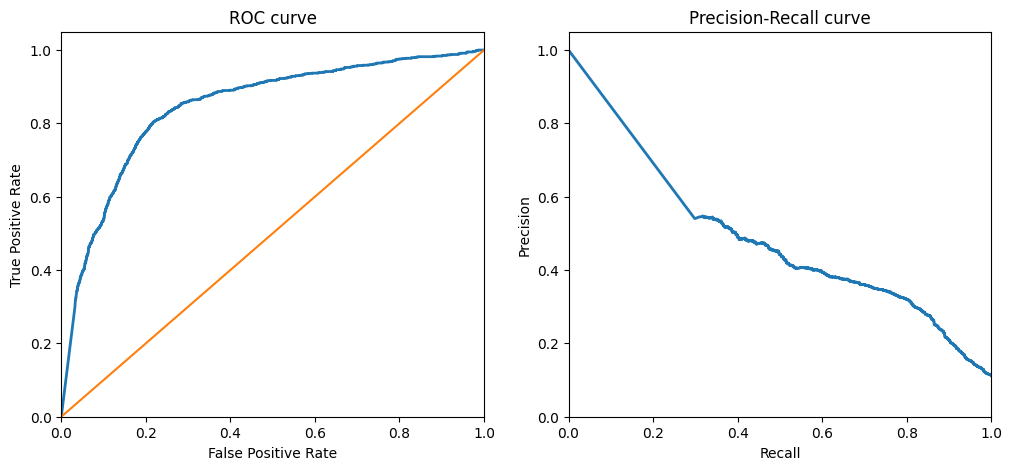

In [26]:
# Gaussian Naive Bayes
start_time = process_time()

# Создаем экземпляр классификатора, обучаем модель на тренировочных данных, получаем прогнозы для тестовых
Bayes = GaussianNB()
Bayes.fit(X_train, y_train)
y_pred = Bayes.predict(X_test)

finish_time = process_time()
sec = finish_time - start_time

# Выводим результаты оценки -площадь под ROC-кривой
results(y_test, y_pred, sec)
print("\n")
print('Площадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, Bayes.predict_proba(X_train)[:,1])))
print("\n")
print('Результат на оценочной выборке' + str(metrics.roc_auc_score(y_test, Bayes.predict_proba(X_test)[:,1])))
# Строим ROC-кривую
ROC_curve(y_test, Bayes)


## **4.8 Метод ближайших соседей K-nn**

              precision    recall  f1-score   support

   recovered       0.94      0.97      0.95      8829
   uncovered       0.64      0.45      0.53      1017

    accuracy                           0.92      9846
   macro avg       0.79      0.71      0.74      9846
weighted avg       0.91      0.92      0.91      9846


Площадь под ROC-кривой - 0.7094


Площадь под ROC-кривой по вероятностям1.0


Результат на оценочной выборке0.8932225114496529


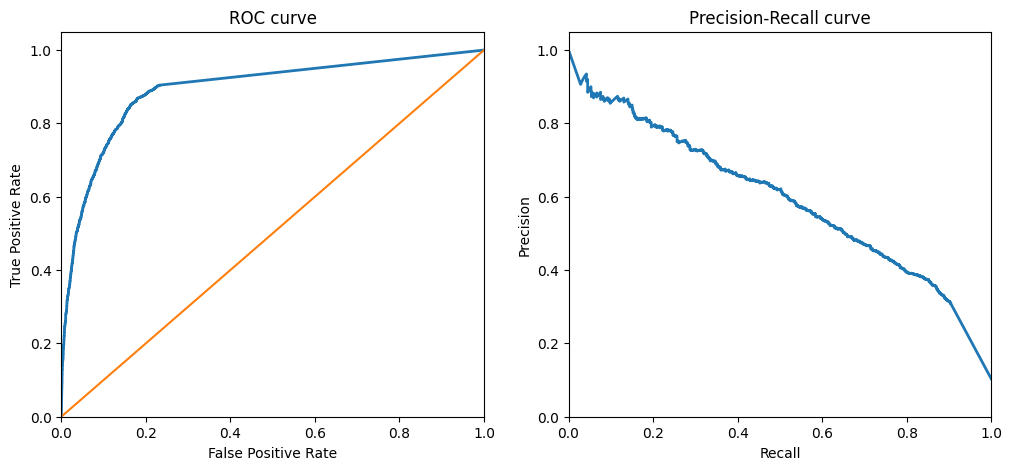

In [81]:
start_time = process_time()
neigh = KNeighborsClassifier(leaf_size=10,
                            metric='manhattan', 
                            n_neighbors=9, 
                            weights='distance')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
finish_time = process_time()
sec = finish_time - start_time


results(y_test, y_pred, sec)
print ("\n")

print('Площадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, neigh.predict_proba(X_train)[:,1])))
print("\n")

print('Результат на оценочной выборке' + str(metrics.roc_auc_score(y_test, neigh.predict_proba(X_test)[:,1])))
ROC_curve(y_test, neigh)

### 4.8.1 Подбор параметров

In [105]:
# Задание параметров для GridSearchCV
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # количество соседей
    'metric': ['euclidean', 'manhattan', 'chebyshev'],  # метрика расстояния
    'weights': ['uniform', 'distance'],  # веса соседей
    'leaf_size': [10, 20, 30, 40],  # размер листа дерева
}
start_time = process_time()
neigh = KNeighborsClassifier()
# Создание объекта GridSearchCV
gr_neigh = GridSearchCV(neigh, parameters, cv=5, scoring="roc_auc", n_jobs=-1)
gr_neigh.fit(X_train, y_train)

finish_time = process_time()
sec = finish_time - start_time
# Вывод результатов
print(f'Время работы: {round(sec)} сек.')
print(f'Лучшие параметры: {gr_neigh.best_params_}')

Время работы: 7 сек.
Лучшие параметры: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


## **4.9 Нейронная сеть MLP**

              precision    recall  f1-score   support

   recovered       0.90      1.00      0.95      8829
   uncovered       0.00      0.00      0.00      1017

    accuracy                           0.90      9846
   macro avg       0.45      0.50      0.47      9846
weighted avg       0.80      0.90      0.85      9846


Площадь под ROC-кривой - 0.5


Площадь под ROC-кривой по вероятностям0.7816453730382493


Результат на оценочной выборке0.7896032483459074


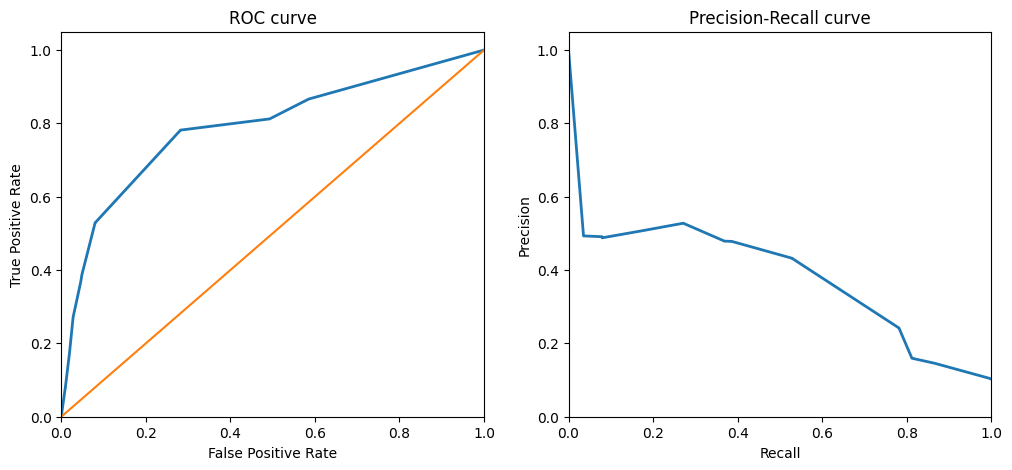

In [82]:
start_time = process_time()
nn = MLPClassifier(activation='logistic', 
                   solver='adam', 
                   hidden_layer_sizes=(100, 100))

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
finish_time = process_time()
sec = finish_time - start_time
results(y_test, y_pred, sec)

print ("\n")
print('Площадь под ROC-кривой по вероятностям'+ str(metrics.roc_auc_score(y_train, nn.predict_proba(X_train)[:,1])))
print("\n")
print('Результат на оценочной выборке' + str(metrics.roc_auc_score(y_test, nn.predict_proba(X_test)[:,1])))
ROC_curve(y_test, nn)

### 4.9.1 Подбор параметров

In [40]:
# Задание параметров для GridSearchCV
parameters = {
    'activation': ['logistic', 'relu'],  # функция активации
    'solver': ['adam', 'sgd'],  # алгоритм оптимизации
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)]  # количество нейронов в скрытых слоях
}

nn = MLPClassifier()
gr_nn = GridSearchCV(nn, parameters, 
                     cv=5, scoring="roc_auc", 
                     n_jobs=-1)

start_time = process_time()
gr_nn.fit(X_train, y_train)
finish_time = process_time()

# Вычисление времени выполнения
sec = finish_time - start_time

# Вывод результатов
print(f'Время работы: {round(sec)}')
print(f'Лучшие параметры: {gr_nn.best_params_}')

Время работы: (1, 46)
Лучшие параметры: {'activation': 'logistic', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}


# **5 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ**
Метод SHAP строит график который позволяет визуализировать важность признаков для модели. На графике признаке отсортированы по вкладу параметра в предсказания модели. 


## **ИТОГО:**
- в качестве итоговой модели принята модель LGBM из-за соотношений метрики - время работы. 
- увеличение значения параметра duration приведет к росту вероятности открытия депозита клиентом (см. ниже)
- уменьшение значения параметра nr_employed приведет к росту вероятности открытия депозита клиентом 


### 5.1 Признаки модели LGBM

 98%|===================| 9694/9846 [00:18<00:00]        

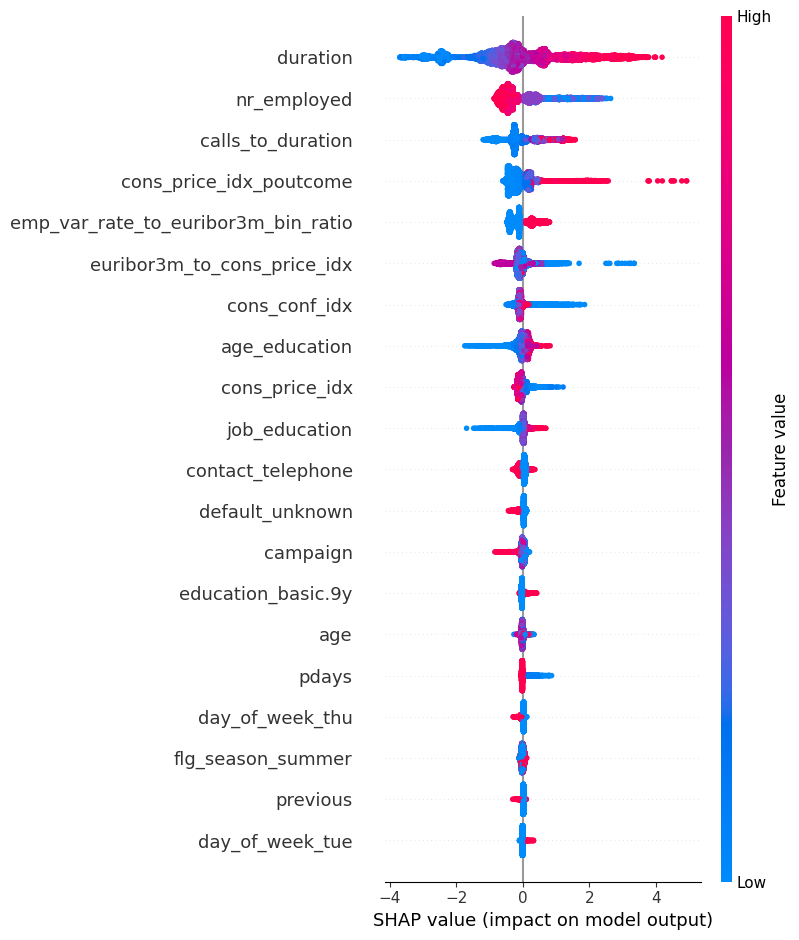

In [68]:
import shap

# Создайте объект TreeExplainer для модели LightGBM
explainer = shap.TreeExplainer(lgb, X_train)

# Получите значения SHAP для тестового набора данных и постройте график суммарного распределения
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 5.2 Признаки линейной модели LogisticRegression

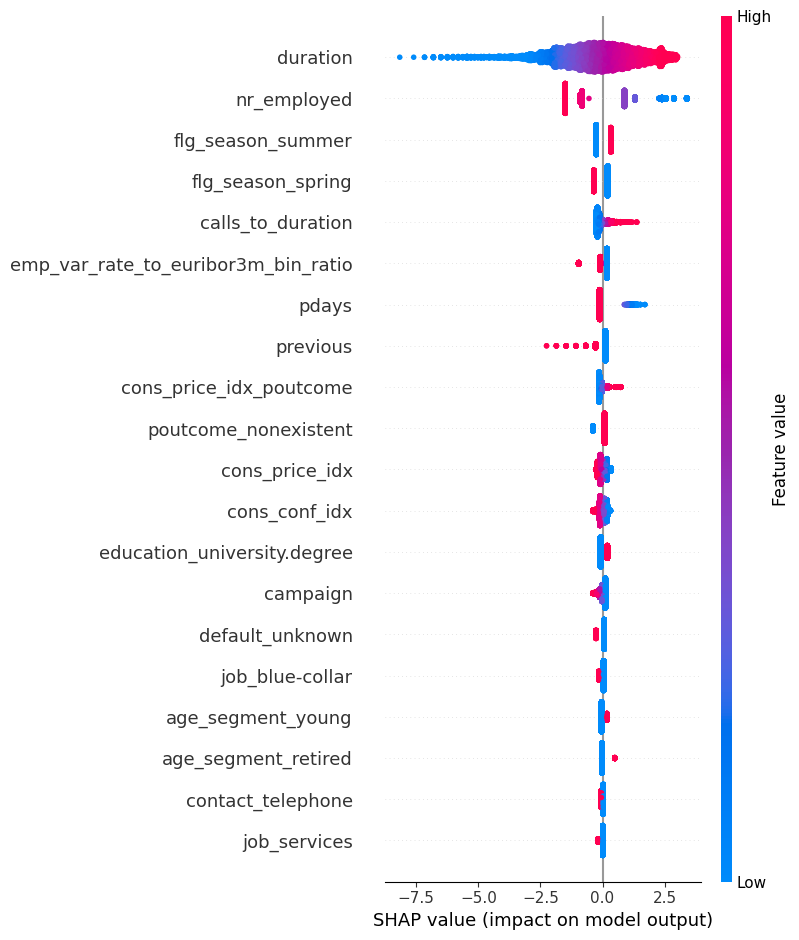

In [83]:
import shap 

# Разберем важность признаков Логистической регрессии
explainer = shap.LinearExplainer(clf, X_train, features_dependence='independed')

# Получение значений SHAP для тестовой выборки и построение графика summary_plot
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)